## Stage 5. 모델 학습 및 검증

### Import Library

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', 
    name='NanumBarunGothic')                      
fm.fontManager.ttflist.insert(0, fe)            
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) 
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# Utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### 1. 데이터 분석 전 준비

In [3]:
pd.options.mode.chained_assignment = None

submission = pd.read_csv('../data/sample_submission.csv')
all_data = pd.read_csv('../data/all_data.csv')

/tmp/ipykernel_579260/396092589.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('../data/all_data.csv')


### 2. 모델 학습 및 검증

In [15]:
all_data.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       '해제사유발생일', '거래유형', '중개사소재지', 'k-단지분류', 'k-세대타입(분양형태)', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황60이하', 'k-전용면적별세대현황6085이하', 'k-85135이하', 'k-135초과',
       '세대전기계약방법', '건축면적', '주차대수', '기타의무임대1234', '단지신청일', 'target', '구', '동',
       '전체주소명', '동아파트명', '유동인구', '아파트 지하철역 거리', '1차역세권', '2차역세권',
       '아파트 버스정류장 거리', '좌표X', '좌표Y', '아파트 한강대교 거리', '전세가율', '전체계약일자', '금리',
       '실질gdp', '명목gdp', '학군', '재개발개수', '학급수', '여당득표율', 'train_test', '계약날짜',
       'apartment_id', 'bucket_area', 'recent_price', 'transaction_cnt',
       '1년전_금리', 'cluster_x', 'low_floor', '계약년', '계약월', 'cluster_y',
       'cluster'],
      dtype='object')

In [16]:
# Random Forest Model 
# Optuna Library 사용(Hyper parameter 최적화)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import optuna

validation_year = 2022

columns = [
    '건축년도','recent_price', 'transaction_cnt', '1년전_금리', '계약년',
    '계약월', 'cluster', 'bucket_area', 'low_floor',
]

train_x = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] < validation_year), columns]
train_y = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] < validation_year), 'target']

val_x = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] == validation_year), columns]
val_y = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] == validation_year), 'target']

def objective(trial):
    # 하이퍼파라미터 탐색 대상
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)

    # RandomForestRegressor 모델 학습
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(train_x, train_y)

    # 검증 데이터로 평가
    y_pred = model.predict(val_x)
    mse = mean_squared_error(val_y, y_pred)
    return mse

# Optuna를 사용하여 하이퍼파라미터 탐색
study = optuna.create_study(direction='minimize')  # 목표는 최소화
study.optimize(objective, n_trials=50)  # 50회 반복하여 탐색

# 최적의 하이퍼파라미터 값 출력
best_params = study.best_params
print("Best Params:", best_params)

[I 2024-01-24 05:17:36,906] A new study created in memory with name: no-name-207e9e0a-1f2d-4c1f-85e9-3d7aa36dc864
[I 2024-01-24 05:21:38,768] Trial 0 finished with value: 930812883.9349685 and parameters: {'n_estimators': 74, 'max_depth': 28}. Best is trial 0 with value: 930812883.9349685.
[I 2024-01-24 05:23:57,128] Trial 1 finished with value: 910370799.4946418 and parameters: {'n_estimators': 86, 'max_depth': 10}. Best is trial 1 with value: 910370799.4946418.
[I 2024-01-24 05:28:17,391] Trial 2 finished with value: 932705847.1725438 and parameters: {'n_estimators': 79, 'max_depth': 28}. Best is trial 1 with value: 910370799.4946418.
[I 2024-01-24 05:31:39,578] Trial 3 finished with value: 929374676.1095756 and parameters: {'n_estimators': 60, 'max_depth': 30}. Best is trial 1 with value: 910370799.4946418.
[I 2024-01-24 05:32:12,426] Trial 4 finished with value: 1313309174.3635514 and parameters: {'n_estimators': 43, 'max_depth': 4}. Best is trial 1 with value: 910370799.4946418.
[

Best Params: {'n_estimators': 59, 'max_depth': 12}


### 3. 모델 학습

In [17]:
from sklearn.metrics import mean_absolute_error

# 최적의 하이퍼파라미터로 모델 재학습
best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'])
best_model.fit(train_x, train_y)

# 예측
pred_val_ls = best_model.predict(val_x)

mae = mean_absolute_error(val_y, pred_val_ls)
print(mae)

14147.4756455995


### 12. 피처 중요도 확인

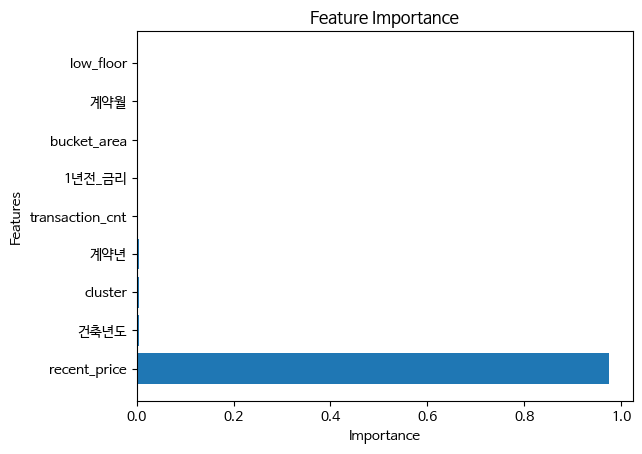

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 이 경로는 시스템에 따라 다를 수 있습니다.

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()

# Matplotlib의 rcParams 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 이제 그래프를 다시 그리면 한글이 제대로 표시됩니다.


importances = best_model.feature_importances_
feature_names = train_x.columns

# 피쳐 중요도에 따라 내림차순으로 인덱스를 정렬
indices = np.argsort(importances)[::-1]

# 피쳐 이름을 중요도 순서에 맞게 재배열
sorted_feature_names = [feature_names[i] for i in indices]

# 피쳐 중요도 시각화
plt.figure()
plt.title("Feature Importance")
plt.barh(range(train_x.shape[1]), importances[indices], align="center")
plt.yticks(range(train_x.shape[1]), sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

### 13. 중요 피처(Feature) 선택

In [ ]:
drop_columns = ['bucket_area', 'low_floor', '계약월']

train_filtered_x = train_x.drop(columns=drop_columns)
val_filtered_x = val_x.drop(columns=drop_columns)

best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'])
best_model.fit(train_filtered_x, train_y)

# 예측
pred_val_ls = best_model.predict(val_filtered_x)
mae = mean_absolute_error(pred_val_ls, val_y)
print(mae)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(pred_val_ls, val_y))
print(validation_year,'년도 RMSE: ', rmse)

### 14. 시계열 모델 교차검증

- 시계열 데이터는 순서가 중요하므로 데이터를 분리할 때 순서가 섞이지 않도록 주의해야 함
- Validation data를 만들 때 Train data 보다 미래가 되도록 만들어야 함

In [31]:
for validation_year in [2018, 2019, 2020, 2021, 2022]:
    columns = [
        'recent_price', 'transaction_cnt', '1년전_금리', '계약년', 'cluster', '건축년도'
    ]
    train_x = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] < validation_year), columns]
    train_y = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] < validation_year), 'target']
    
    val_x = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] == validation_year), columns]
    val_y = all_data.loc[(all_data['train_test'] == 'train') & (all_data['계약년'] == validation_year), 'target']
    
    # 랜덤 포레스트 모델 생성 및 훈련
    model_trial = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth']
    )
    model_trial.fit(train_x, train_y)
    
    # 예측
    pred_val_ls = model_trial.predict(val_x)
    mae = mean_absolute_error(pred_val_ls, val_y)
    print(validation_year,'년도 MAE: ' , mae)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(pred_val_ls, val_y))
    print(validation_year,'년도 RMSE: ', rmse)

2018 년도 MAE:  5889.060288115093
2018 년도 RMSE:  12381.941360808756
2019 년도 MAE:  7198.08519565768
2019 년도 RMSE:  14359.762136374893
2020 년도 MAE:  7216.982360272215
2020 년도 RMSE:  13901.01022995256
2021 년도 MAE:  10204.667501691849
2021 년도 RMSE:  22601.26885157267
2022 년도 MAE:  14551.404676133074
2022 년도 RMSE:  29920.738278135083


### 15. 테스트 데이터 예측

In [25]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from datetime import datetime

def make_area_bucket(area):
    if area < 60: # 59타입
        return 0
    elif area < 85: # 84타입
        return 1
    else:
        return 2


# 아파트 면적 전처리
all_data['bucket_area'] = all_data['전용면적'].apply(make_area_bucket)

def get_recent_price(idx, all_data):
    temp_df = all_data.loc[:idx]
    temp_df = temp_df[
        (temp_df['계약날짜'] < row['계약날짜']) &
        (temp_df['bucket_area'] == row['bucket_area'])
    ]
    if len(temp_df) == 0:
        temp_df = all_data[
            (all_data['계약날짜'] < datetime.strptime('2016-01-01', "%Y-%m-%d")) &
            (all_data['bucket_area'] == row['bucket_area'])
        ]
    
    # 아파트 아이디 같은것 찾기
    recent_price = temp_df[(temp_df['apartment_id'] == row['apartment_id'])]
    if len(recent_price) == 0:
        recent_price = temp_df[(temp_df['시군구'] == row['시군구'])]
        recent_price = recent_price.iloc[-1]['target']
    else:
        recent_price = recent_price.iloc[-1]['target']  
    
    if recent_price is None:
        recent_price = temp_df['target'].mean() # 2019년 전체평균

    return recent_price


columns = [
    'recent_price', 'transaction_cnt', '1년전_금리', '계약년', 'cluster', '건축년도' 
]
train_x = all_data.loc[all_data['train_test'] == 'train', columns]
train_y = all_data.loc[all_data['train_test'] == 'train', 'target']
test_x = all_data.loc[all_data['train_test'] == 'test', columns]

# 랜덤 포레스트 모델 생성 및 훈련
model = RandomForestRegressor()
model.fit(train_x, train_y)

# 예측
pred_ls = list()
now_df = all_data.loc[all_data['train_test'] == 'train']
test = all_data.loc[all_data['train_test'] == 'test']

for idx, row in tqdm(test.iterrows(), total = test.shape[0]):
    now_df = pd.concat([now_df, test.loc[[idx]]])
    test_x.loc[idx, 'recent_price'] = get_recent_price(idx, now_df)
    
    pred = model.predict(test_x.loc[idx:idx])
    
    now_df.loc[idx, 'target'] = pred
    pred_ls.append(pred[0])

100%|██████████| 9272/9272 [1:37:28<00:00,  1.59it/s]


### 16. 정답 제출 파일 생성

In [30]:
submission['target'] = pred_ls
submission.to_csv('../data/0124_RFmodel.csv', index=False)